In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imread_collection
from skimage.transform import resize
import os
import sys
from tqdm import tqdm
import tensorflow as tf
import time
import dill

DATA_PATH = "NU_data/"
TRAIN_PATH = DATA_PATH+"stage1_train/"
HEIGHT = 128
WIDTH = 128
cases = os.listdir(TRAIN_PATH)

try:
    dill.load_session('notebook_env.db')
    print ("读取环境变量")
except:
    print ("环境变量文件没找到")

读取环境变量


In [ ]:
#prepare the data
images = np.zeros((len(cases),HEIGHT, WIDTH,3), dtype=np.uint8)
labels = np.zeros((len(cases),HEIGHT, WIDTH,1), dtype=np.bool)

print('Getting and resizing TRAIN images and masks ... ')

for c_i, c in tqdm(enumerate(cases), total=len(cases)):
    #get and resize image
    img = imread(TRAIN_PATH+"{}/images/{}.png".format(c,c))[:, :, :3]
    img = resize(img, (HEIGHT, WIDTH, 3), mode='constant', preserve_range=True)
    images[c_i] =img
    
    #get and resize mask
    label = np.zeros((HEIGHT, WIDTH,1), dtype=np.bool)
    masks = imread_collection(TRAIN_PATH+ "{}/masks/*".format(c)).concatenate()
    masks = np.expand_dims(masks,-1)
    for m_i, m in enumerate(masks):
        m = resize(m, (HEIGHT, WIDTH, 1), mode='constant')
        label = np.maximum(label,m)
    labels[c_i] =label

print('Done!')
print(len(images))

dill.dump_session('notebook_env.db')

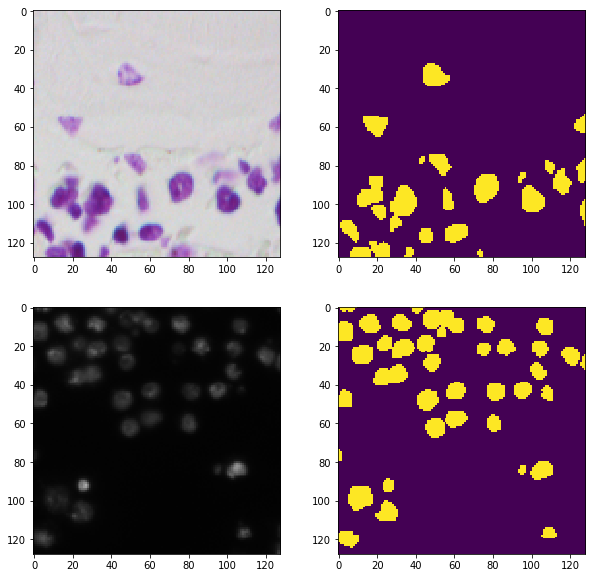

In [7]:
class Dataset:
    'dataset'
    def __init__(self, images, labels):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._images = images/255
        self._labels = labels/1
        self._num_examples = images.shape[0]
        pass
    
    @property
    def data(self):
        return self._images, self._labels

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        end = self._index_in_epoch + batch_size

        if end > self._num_examples or start==0: 
          # Finished epoch
          self._epochs_completed += 1
          # Shuffle the data
          p = np.arange(self._num_examples)
          np.random.shuffle(p)
          self._images = self._images[p]
          self._labels = self._labels[p]
          # Start next epoch
          start = 0
          end = batch_size
            
        self._index_in_epoch = end
        return self._images[start:end], self._labels[start:end]

dataset = Dataset(images, labels)
x_batch, y_batch = dataset.next_batch(9);

num = 2
fig, axs = plt.subplots(num, 2, figsize=(10, num*5))
for i in range(num):
    axs[i,0].imshow(x_batch[i],cmap='hot')
        
    axs[i,1].imshow(y_batch[i][:,:,0])

In [44]:
def conv2d(x, depth, kernel, strides=1, activation = tf.nn.relu):
    return tf.layers.conv2d(x, depth, kernel, strides= strides, padding= 'same', activation = activation)

def maxpool2d(x, strides= 2):
    return tf.layers.max_pooling2d(x, pool_size = 2, strides = strides, padding = 'same')

def upconv2d(x, depth, kernel, strides= 2):
    return tf.layers.conv2d_transpose(x, depth, kernel, strides = strides, padding = 'same')

def unet(X):
    D1_1 = conv2d(X, 32, 3)
    D1_2 = conv2d(D1_1, 32, 3)
    
    P1 = maxpool2d(D1_2)#1/2
    D2_1 = conv2d(P1, 64, 3)
    D2_2 = conv2d(D2_1, 64, 3)
    
    P2 = maxpool2d(D2_2) #1/4
    D3_1 = conv2d(P2, 128, 3)
    D3_2 = conv2d(D3_1, 128, 3)
    D3_2 = tf.nn.relu(D3_2)
    
    P3 = maxpool2d(D3_2)#1/8
    D4_1 = conv2d(P3, 256, 3)
    D4_2 = conv2d(D4_1, 256, 3)
    
    U1 = upconv2d(D4_2, 128, 2)#1/4
    U1 = tf.concat([U1, D3_2],3)
    C1_1 = conv2d(U1, 128, 3)
    C1_2 = conv2d(C1_1, 128, 3)
    
    U2 = upconv2d(C1_2, 64, 2)#1/2
    U2 = tf.concat([U2, D2_2],3)
    C2_1 = conv2d(U2, 64, 3)
    C2_2 = conv2d(C2_1, 64, 3)
    
    U3 = upconv2d(C2_2, 32, 2)
    U3 = tf.concat([U3, D1_2],3)
    C3_1 = conv2d(U3, 32, 3)
    C3_2 = conv2d(C3_1, 32, 3)
    
    Drop = tf.layers.dropout(C3_2, rate=0.5, training=train_mode)
    
    return conv2d(Drop, 1, 1, activation = None)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#tensorboard --logdir=F:\python\tensorflowLearn\NU_train --host=127.0.0.1

with tf.Graph().as_default() as graph:
    x_ = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 3])
    y_ = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 1])
    train_mode = tf.placeholder(tf.bool)
    
    logits = unet(x_)
    preds = tf.sigmoid(logits)
    loss = tf.losses.sigmoid_cross_entropy(y_, logits)
    train_step = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    saver = tf.train.Saver()
    tf.add_to_collection('x_',x_)
    tf.add_to_collection('y_',y_)
    tf.add_to_collection('train_mode',train_mode)
    tf.add_to_collection('logits',logits)
    tf.add_to_collection('loss',loss)
    tf.add_to_collection('preds',preds)
    
    s_loss = tf.summary.scalar("loss", loss)
    merged = tf.summary.merge([s_loss])# this is a fixed bug with jupyter: merge_all not working here

  7%|█████▊                                                                        | 747/10000 [01:10<14:27, 10.67it/s]

In [45]:
def time_string():
    return time.strftime('%Y%m%d%H%M%S',time.localtime(time.time()))

with tf.Session(config = config, graph = graph) as sess:
    sess.run(tf.global_variables_initializer())
    s_writer = tf.summary.FileWriter("NU_train/"+time_string(), sess.graph)
    
    for i in tqdm(range(10000)):
        x_batch, y_batch = dataset.next_batch(10)
        _, los, s  = sess.run(
            [train_step, loss, merged],
            feed_dict={x_: x_batch, y_: y_batch, train_mode: True}
         )
        s_writer.add_summary(s, i)
        
        if (i+1) % 1000 == 0:
            pass
            print('iteration', i, 'loss', los,)
    
    # Save the variables to disk.
    save_path = saver.save(sess, "NU_model/"+time_string())
    print ("Model saved in file: ", save_path)


 10%|███████▊                                                                      | 998/10000 [01:08<10:20, 14.52it/s]

iteration 999 loss 0.10123239


 20%|███████████████▍                                                             | 1998/10000 [02:17<09:10, 14.54it/s]

iteration 1999 loss 0.08039896


 30%|███████████████████████                                                      | 2998/10000 [03:26<08:01, 14.54it/s]

iteration 2999 loss 0.09565798


 40%|██████████████████████████████▊                                              | 3998/10000 [04:34<06:52, 14.55it/s]

iteration 3999 loss 0.04878838


 50%|██████████████████████████████████████▍                                      | 4998/10000 [05:43<05:43, 14.56it/s]

iteration 4999 loss 0.115806326


 60%|██████████████████████████████████████████████▏                              | 5998/10000 [06:52<04:35, 14.55it/s]

iteration 5999 loss 0.02698775


 70%|█████████████████████████████████████████████████████▉                       | 6998/10000 [08:01<03:26, 14.54it/s]

iteration 6999 loss 0.03823943


 80%|█████████████████████████████████████████████████████████████▌               | 7998/10000 [09:10<02:17, 14.52it/s]

iteration 7999 loss 0.022905681


 90%|█████████████████████████████████████████████████████████████████████▎       | 8998/10000 [10:21<01:09, 14.49it/s]

iteration 8999 loss 0.09724522


100%|████████████████████████████████████████████████████████████████████████████▉| 9998/10000 [11:30<00:00, 14.48it/s]

iteration 9999 loss 0.013615375


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:30<00:00, 14.48it/s]


Model saved in file:  NU_model/20180425203226


INFO:tensorflow:Restoring parameters from NU_model/20180425200824
Model loaded.
0.008135222


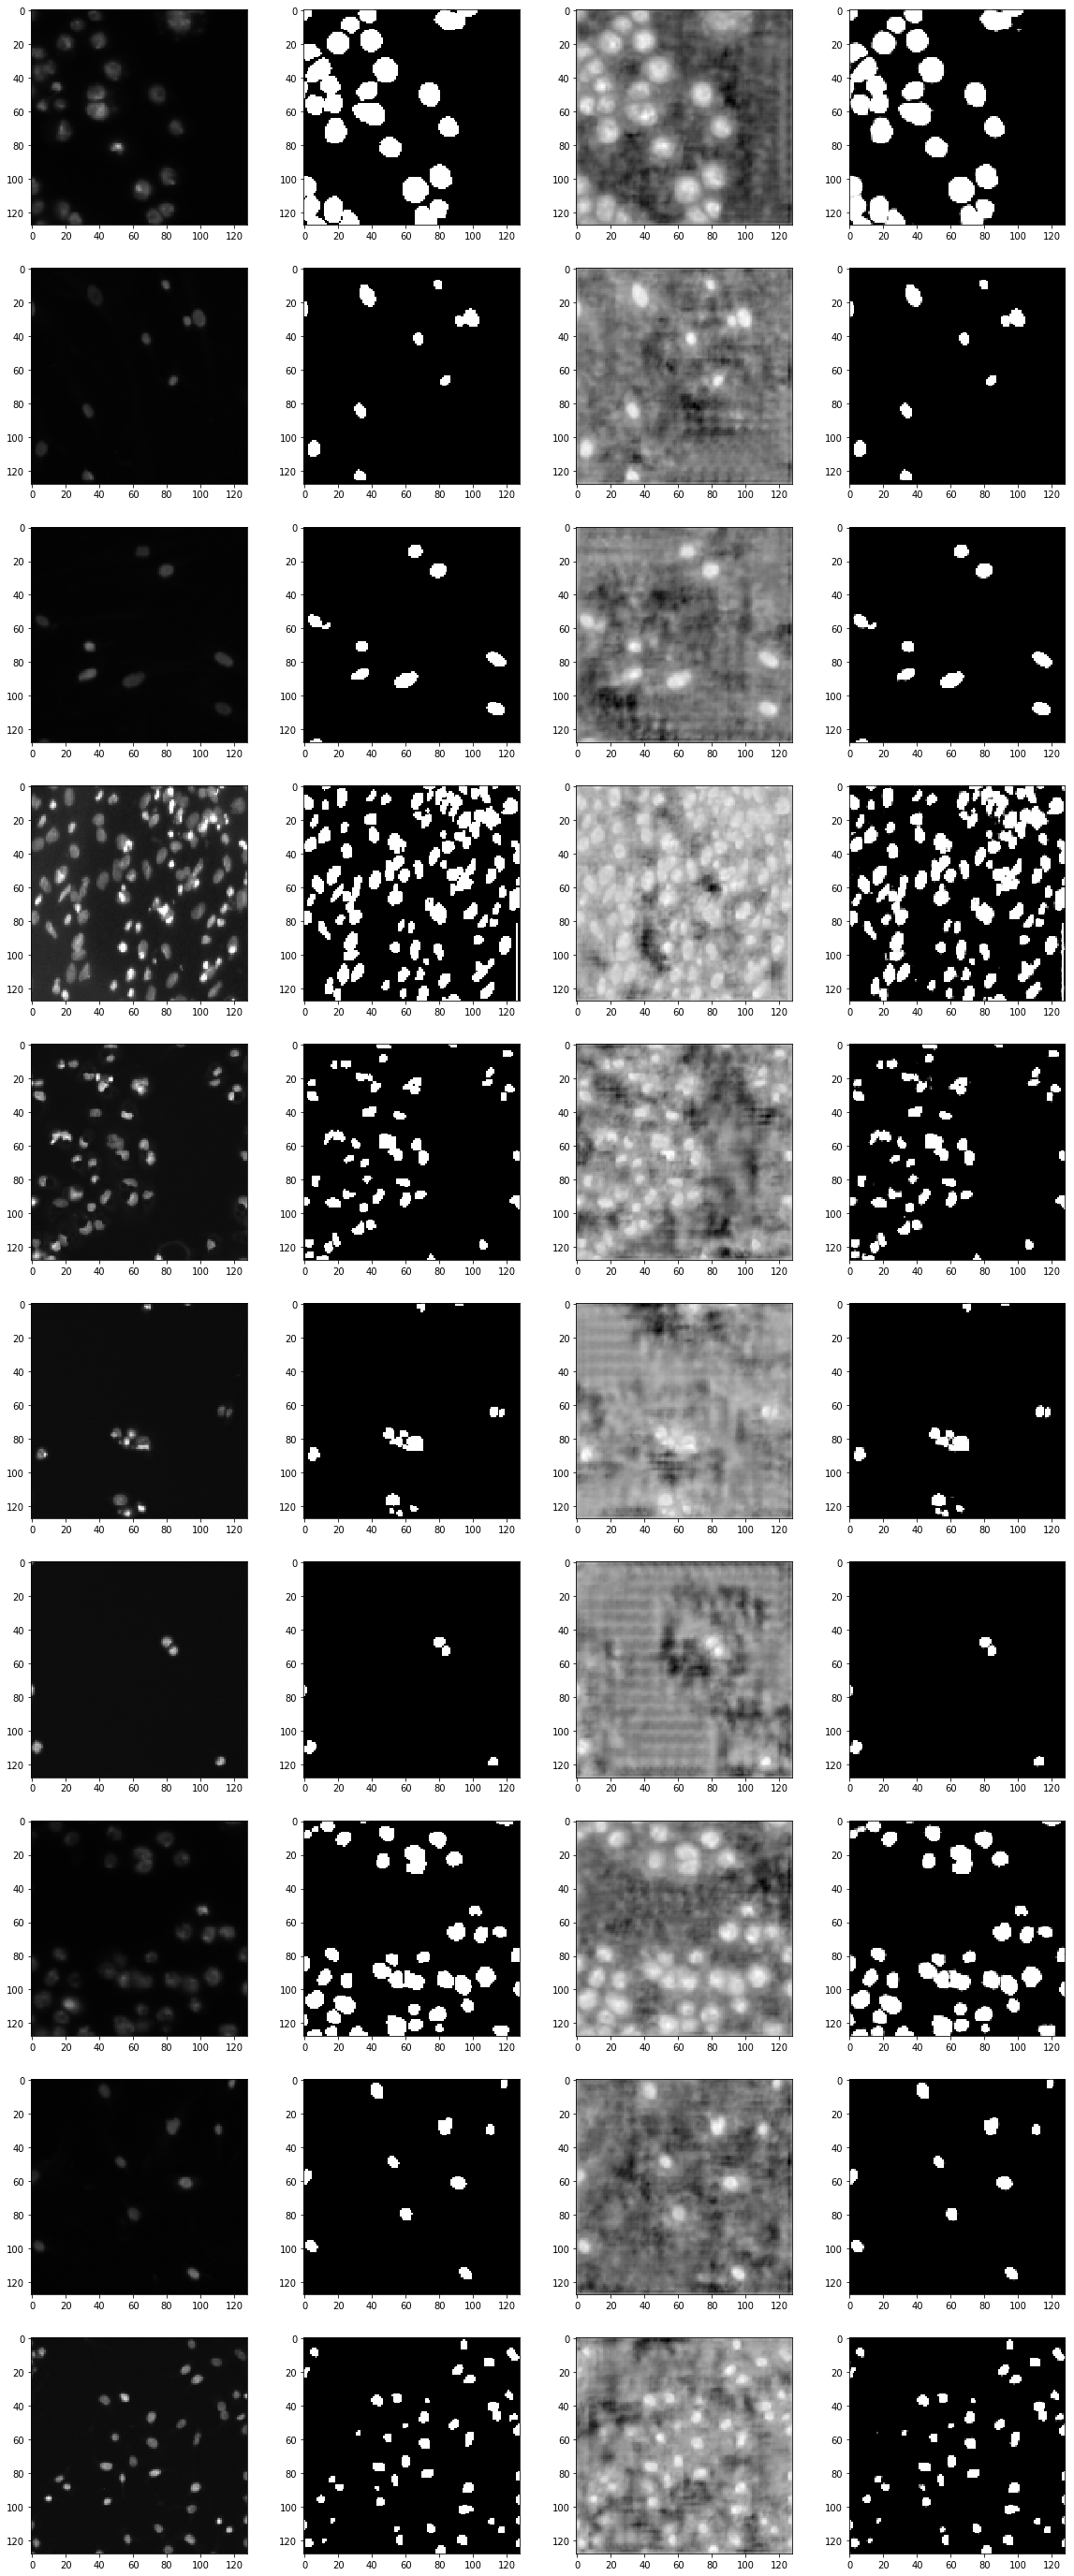

In [41]:
with tf.Session(graph = graph) as sess:
    #20180423133753   
    #20180425203226
    
    # Restore variables from disk.
    module_file = tf.train.latest_checkpoint('NU_model/')
    #module_file = 'NU_model/20180425200824'
    #saver = tf.train.import_meta_graph(module_file+'.meta')
    saver.restore(sess, module_file)
    print ("Model loaded.")
    
    arr = np.arange(400,410)
    test_images = images[arr]/255
    test_labels = labels[arr]/1  
    
    log, prd, los= sess.run(
        [logits, preds, loss],
        feed_dict={x_: test_images, y_: test_labels, train_mode: False}
    )
    
    num = len(arr)

    print (los)
    
    fig, axs = plt.subplots(num, 4, figsize=(20, num*5))
    axs = axs.ravel()
    for i in range(num):
        axs[i*4].imshow(test_images[i])

        axs[i*4+1].imshow(test_labels[i][:,:,0], cmap='gray')
        
        axs[i*4+2].imshow(log[i][:,:,0], cmap='gray')
    
        axs[i*4+3].imshow(prd[i][:,:,0], cmap='gray')